In [1]:
%pip install pandas prophet scikit-learn plotly


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
weather = pd.read_csv('manipulatedWeatherData.csv')

In [3]:
from prophet import Prophet

In [4]:
weather["datetime"]=pd.to_datetime(weather["datetime"])
cols_to_drop = [col for col in weather.columns if col.endswith('GA')]
weather.drop(cols_to_drop, axis=1, inplace=True)

weather

,datetime,sealevelpressureSC,tempSC,humiditySC,solarradiationSC,dayofyear,hour,tempSS,feelslikeSS,dewSS,...,precipprobCO,snowCO,snowdepthCO,windspeedCO,winddirCO,sealevelpressureCO,cloudcoverCO,visibilityCO,solarradiationCO,uvindexCO
0,2019-01-01 00:00:00,1007.8,4.2,86.15,0.0,1,0,-3.4,-6.9,-9.2,...,0.0,0.0,0.00,11.4,325.0,1021.4,43.8,16.0,0.0,0.0
1,2019-01-01 01:00:00,1004.6,4.8,82.71,0.0,1,1,-4.2,-8.2,-9.0,...,0.0,0.0,0.00,10.1,318.0,1022.2,51.7,16.0,0.0,0.0
2,2019-01-01 02:00:00,1002.8,5.0,85.67,0.0,1,2,-4.7,-9.2,-9.5,...,0.0,0.0,0.00,17.8,295.0,1023.1,11.9,16.0,0.0,0.0
3,2019-01-01 03:00:00,1001.7,5.7,85.02,0.0,1,3,-4.7,-8.3,-9.5,...,0.0,0.0,0.00,11.6,289.0,1024.2,11.9,16.0,0.0,0.0
4,2019-01-01 04:00:00,999.2,6.2,85.20,0.0,1,4,-5.1,-5.1,-9.5,...,0.0,0.0,0.00,8.9,308.0,1024.7,15.0,16.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2022-12-31 19:00:00,1009.0,11.0,91.61,0.0,365,19,2.8,2.8,0.5,...,0.0,0.0,1.62,3.5,256.0,1014.5,90.1,16.0,0.0,0.0
35060,2022-12-31 20:00:00,1007.9,11.1,91.70,0.0,365,20,2.8,2.8,0.5,...,0.0,0.0,1.50,1.3,343.0,1015.3,100.0,16.0,0.0,0.0
35061,2022-12-31 21:00:00,1006.9,11.0,91.93,0.0,365,21,3.4,3.4,1.1,...,0.0,0.0,1.37,1.1,339.0,1015.8,100.0,16.0,0.0,0.0
35062,2022-12-31 22:00:00,1006.3,10.6,94.73,0.0,365,22,2.7,2.7,0.9,...,0.0,0.0,1.25,3.9,259.0,1015.8,100.0,16.0,0.0,0.0


In [5]:
weather['ds']=pd.DatetimeIndex(weather['datetime'])
weather_temp = weather.copy()
weather_SR = weather.copy()
weather_temp["y"] = weather_temp.shift(-24)["tempSC"]
weather_SR["y"] = weather_SR.shift(-24)["solarradiationSC"]

weather_temp = weather_temp.ffill()
weather_SR = weather_SR.ffill()
predictors = weather.columns[~weather.columns.isin(["y","ds"])]



In [6]:

train_temp = weather_temp[:26304]
test_temp = weather_temp[26304:]
test_temp = test_temp.reset_index(drop=True)


train_SR = weather_SR[:26304]
test_SR  = weather_SR[26304:]
test_SR  = test_SR.reset_index(drop=True)


In [7]:
def fit_prophet(train):
    m = Prophet()
    for p in predictors:
        m.add_regressor(p)  
    m.fit(train)
    return m

mT = fit_prophet(train_temp)
mSR = fit_prophet(train_SR)
predictionsT = mT.predict(test_temp)
predictionsSR = mSR.predict(test_SR)

20:13:54 - cmdstanpy - INFO - Chain [1] start processing
20:14:50 - cmdstanpy - INFO - Chain [1] done processing
20:14:58 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
abs_diffT = np.abs(predictionsT['yhat'] - test_temp["y"])  # calculate absolute difference
tempArr=[0]*8
for i in range(8):
    within_one_degreeT = abs_diffT <= (i+1)*0.5  # create boolean array where elements within 1 degree
    percent_within_one_degreeT = np.mean(within_one_degreeT) * 100  # calculate percentage
    tempArr[i] = percent_within_one_degreeT
tempArr



[73.08219178082192,
 95.39954337899543,
 99.28082191780821,
 99.74885844748859,
 99.76027397260275,
 99.77168949771689,
 99.80593607305937,
 99.82876712328768]

In [9]:
# Clip predicted values at 0
predictionsSR[['yhat']] = predictionsSR[['yhat']].clip(lower=0)

# Set threshold value
threshold = 2

# Create boolean array to indicate non-zero and above threshold values in actual
non_zero_above_threshold = ((test_SR['y'].values > threshold) & (test_SR['y'].values != 0))
abs_diff = np.abs(predictionsSR['yhat'] - test_SR["y"])
SRArr=[0]*7
for i in range(7):
    within_25_percent = (abs_diff[non_zero_above_threshold] / test_SR['y'].values[non_zero_above_threshold]) <= (0.05*(i+1)+0.05)
    percent_within_25_percent = np.mean(within_25_percent) * 100
    SRArr[i] = percent_within_25_percent

SRArr

[15.664808917197453,
 22.830414012738853,
 29.637738853503187,
 35.788216560509554,
 41.56050955414013,
 46.496815286624205,
 51.47292993630573]

In [10]:
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric

from prophet.utilities import regressor_coefficients

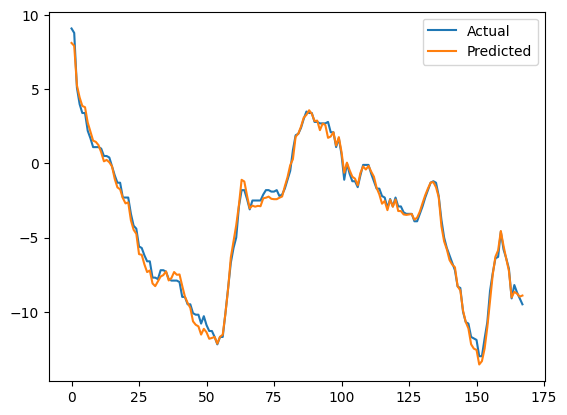

In [11]:
from matplotlib import pyplot
predictions_weekT = predictionsT.iloc[:168]
test_weekT = test_temp.iloc[:168]
pyplot.plot(test_weekT['y'], label='Actual')
pyplot.plot(predictions_weekT['yhat'], label='Predicted')
pyplot.legend()
pyplot.show()

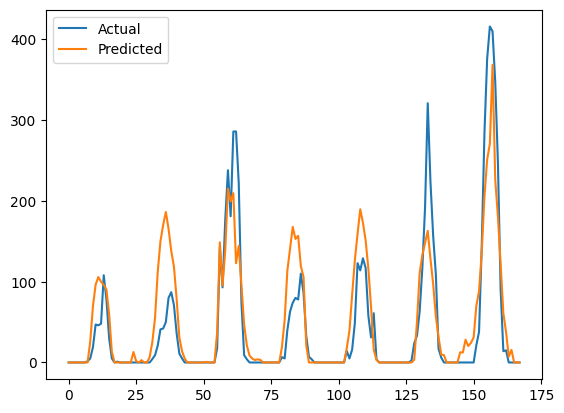

In [12]:
from matplotlib import pyplot
predictions_weekSR = predictionsSR.iloc[:168]
test_weekSR = test_SR.iloc[:168]
pyplot.plot(test_weekSR['y'], label='Actual')
pyplot.plot(predictions_weekSR['yhat'], label='Predicted')
pyplot.legend()
pyplot.show()

In [13]:
#retrain with all data
mT = fit_prophet(weather_temp)
mSR = fit_prophet(weather_SR)

In [14]:
import pickle

 # save the model to a file
with open('tempModel.pkl', 'wb') as f:
    pickle.dump(mT, f)
    
with open('solarRadModel.pkl', 'wb') as f:
    pickle.dump(mSR, f)